# Human Activity Recognition
This notebook provides some guidelines for building a classifier for the MotionSense dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Generate time-series data
The original MotionSense dataset comes in a slightly cumbersome format, but the authors do provide a few functions to produce Pandas DataFrames with control over what is produced. For our purposes we are not concerned with all of the target data, as we only need to know the activity that was being recorded. 

In [3]:
def get_ds_infos():
    """
    Read the file includes data subject information.

    EEE4114: Technically we do not need these data, as we are not concerned about identifying the subjects. 
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains information about data subjects' attributes 
    """ 

    dss = pd.read_csv("../data/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset. 

    EEE4114F: Choose sensors that you think are useful or would like to include in training. 
    You can choose all of them, or you could opt to try a limited set of input features
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    EEE4114F: This defines what data you would like to include for a given set.  

    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimension of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeled dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = '../data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

In [4]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS #[0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


In [5]:
def windows(dataset, window_size=400, stride=200):
    """
    Create fixed-length windows of the input data. 

    Args:
        dataset: DataFrame of the time-series data
        size: (int) the size of the windows in number of samples.
        stride: (int) the stride length of the windows. 

    Returns:
        windows_df: DataFrame of the windowed time-series data. Each window should have the shape (n_sensors, window_size). 
            The number of examples will change depending on the stride.    

    """

    features = dataset.iloc[:, :-1].values  # Shape: (N, 6)
    labels = dataset.iloc[:, -1].values     # Shape: (N,)
    
    windows_list = []
    
    for start in range(0, len(dataset) - window_size + 1, stride):
        end = start + window_size
        window = features[start:end].T  # Transpose to shape (6, window_size)
        window_labels = labels[start:end]
        label = Counter(window_labels).most_common(1)[0][0]  # Mode label
        windows_list.append((window, label))

    return windows_list



#====================================================================================

def windows_no_event_overlap(dataset, window_size=400, stride=200):
    features = dataset.iloc[:, :-1].values  # All sensor columns (shape: N x 6)
    labels = dataset.iloc[:, -1].values     # Activity labels (shape: N,)

    windows_list = []
    start = 0
    N = len(dataset)

    while start + window_size <= N:
        end = start + window_size
        current_labels = labels[start:end]

        # If all labels in the window are the same, accept the window
        if np.all(current_labels == current_labels[0]):
            window = features[start:end].T  # Shape: (6, window_size)
            label = current_labels[0]       # Label is just that class
            windows_list.append((window, label))
            start += stride
        else:
            # Skip ahead until we find a new contiguous segment of the same activity
            next_change = np.where(labels[start:] != labels[start])[0]
            if len(next_change) == 0:
                break  # No more activity changes
            start += next_change[0]  # Move to the start of the next activity block

    return windows_list
    
#========================================================================================

blah = windows(dataset)
print(len(blah))
np.shape(blah[7062][0])

#========================================================================================

x = [x[0] for x in blah]
y = [x[1] for x in blah]
np.shape(x)

7063


(7063, 6, 400)

In [6]:
#========================================================================================

class MotionSense(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X.values)
        self.Y = torch.tensor(Y.values)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

#========================================================================================

class MotionSense2(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

In [7]:
X = dataset[dt_list[0]+dt_list[1]] # You could collect the input and target data as separate dataframes
Y = dataset.act

# You may be tempted to use train_test_split directly. But if using raw sensor data this would randomize the signals and not retain the order. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False) 

X_train.head() 

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299


In [8]:
# Split the data - Holdout
train_set, test_set = train_test_split(blah, test_size=0.2, shuffle=False)


x_train = [x[0] for x in train_set]
y_train = [x[1] for x in train_set]

x_test = [x[0] for x in test_set]
y_test = [x[1] for x in test_set]

In [9]:
#========================================================================================

# Here is an example of the TimeSeriesSplit. It does create cross-validation data by default. 
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=10000,
    test_size=1000
)

all_splits = list(ts_cv.split(X ,Y)) # These are indices, not the data itself.


#========================================================================================

len(all_splits)


#========================================================================================

X.iloc[all_splits[0][0]].head() # This is the training input data from the first split
#print(all_splits)

#========================================================================================
Y.iloc[all_splits[0][0]].head() # This is the training target data from the first split. You can see the indices still match, and arre ordered correctly.

#========================================================================================
dataset.iloc[all_splits[0][0]]



#========================================================================================
train_1 = MotionSense(X.iloc[all_splits[0][0]].reset_index(drop=True), Y.iloc[all_splits[0][0]].reset_index(drop=True)) # reset_index is to make sure each new set is indexed from 0
train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

#========================================================================================
train_1 = MotionSense2(x_train, y_train) # reset_index is to make sure each new set is indexed from 0
train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

#========================================================================================
train_1_loader


#========================================================================================
#for X, Y in train_1_loader:
#    print(f"X={X}, Y={Y}")
dataset.iloc[all_splits[0][0]].shape

/tmp/ipykernel_301082/92527168.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(X)


(10000, 7)

# 1. Data Preparation for LSTM

LSTMs expect input shape (samples, timesteps, features). We'll reshape your windowed data accordingly:

In [10]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert your existing windows to LSTM-friendly format
# x_train shape: [num_samples, 6, 400] -> [num_samples, 400, 6] (LSTM expects seq_len first)
X_train_lstm = np.array([window.T for window in x_train])  # Transpose to (samples, 400, 6)
X_test_lstm = np.array([window.T for window in x_test])    # Same for test set

# Convert labels to tensors
y_train_lstm = torch.LongTensor(y_train)
y_test_lstm = torch.LongTensor(y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.FloatTensor(X_train_lstm), y_train_lstm)
test_dataset = TensorDataset(torch.FloatTensor(X_test_lstm), y_test_lstm)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 2. LSTM Model Architecture

We'll use a bidirectional LSTM to capture both past and future context:

In [11]:
class HAR_LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, num_layers=2, num_classes=6):
        super(HAR_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch, seq_len, hidden_dim*2]
        
        # Use only the last timestep's output
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        return self.fc(last_output)

# 3. Training the LSTM

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HAR_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
lstm_train_acc = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()
    
    train_acc = 100 * correct / len(train_dataset)
    lstm_train_acc.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/20, Loss: 121.2248, Accuracy: 46.09%
Epoch 2/20, Loss: 108.9469, Accuracy: 53.24%
Epoch 3/20, Loss: 95.6634, Accuracy: 59.95%
Epoch 4/20, Loss: 65.3754, Accuracy: 73.61%
Epoch 5/20, Loss: 57.8953, Accuracy: 76.44%
Epoch 6/20, Loss: 46.3076, Accuracy: 79.88%
Epoch 7/20, Loss: 52.5027, Accuracy: 78.90%
Epoch 8/20, Loss: 43.5873, Accuracy: 82.34%
Epoch 9/20, Loss: 45.9579, Accuracy: 81.42%
Epoch 10/20, Loss: 66.0357, Accuracy: 74.30%
Epoch 11/20, Loss: 50.9386, Accuracy: 79.35%
Epoch 12/20, Loss: 47.8925, Accuracy: 80.64%
Epoch 13/20, Loss: 71.9039, Accuracy: 73.17%
Epoch 14/20, Loss: 54.2412, Accuracy: 78.85%
Epoch 15/20, Loss: 44.4288, Accuracy: 81.29%
Epoch 16/20, Loss: 37.7769, Accuracy: 84.65%
Epoch 17/20, Loss: 33.6931, Accuracy: 86.50%
Epoch 18/20, Loss: 30.2102, Accuracy: 88.07%
Epoch 19/20, Loss: 52.7748, Accuracy: 80.04%
Epoch 20/20, Loss: 86.2427, Accuracy: 64.67%


# Accuracy plot

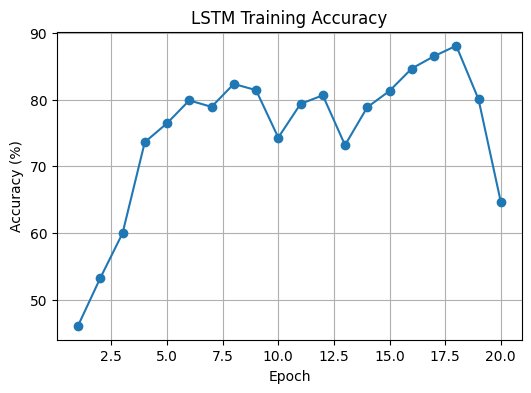

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), lstm_train_acc, marker='o')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()


# Confusion matrics

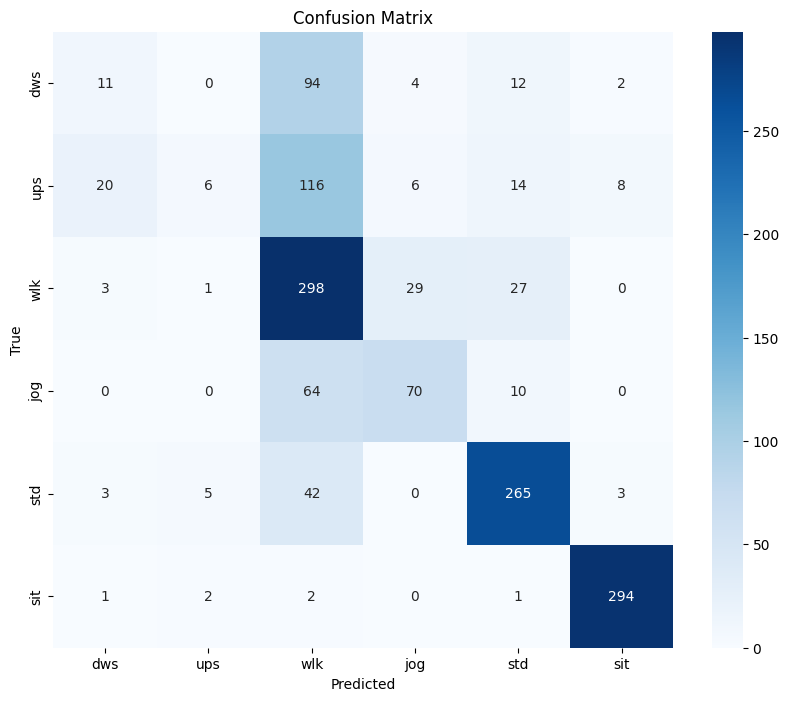

In [15]:



model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

plot_confusion_matrix(all_true, all_preds, classes=ACT_LABELS)

In [16]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(all_true, all_preds, target_names=ACT_LABELS, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Print table in text
print(df_report)

              precision    recall  f1-score      support
dws            0.289474  0.089431  0.136646   123.000000
ups            0.428571  0.035294  0.065217   170.000000
wlk            0.483766  0.832402  0.611910   358.000000
jog            0.642202  0.486111  0.553360   144.000000
std            0.805471  0.833333  0.819165   318.000000
sit            0.957655  0.980000  0.968699   300.000000
accuracy       0.668082  0.668082  0.668082     0.668082
macro avg      0.601190  0.542762  0.525833  1413.000000
weighted avg   0.649373  0.668082  0.621193  1413.000000


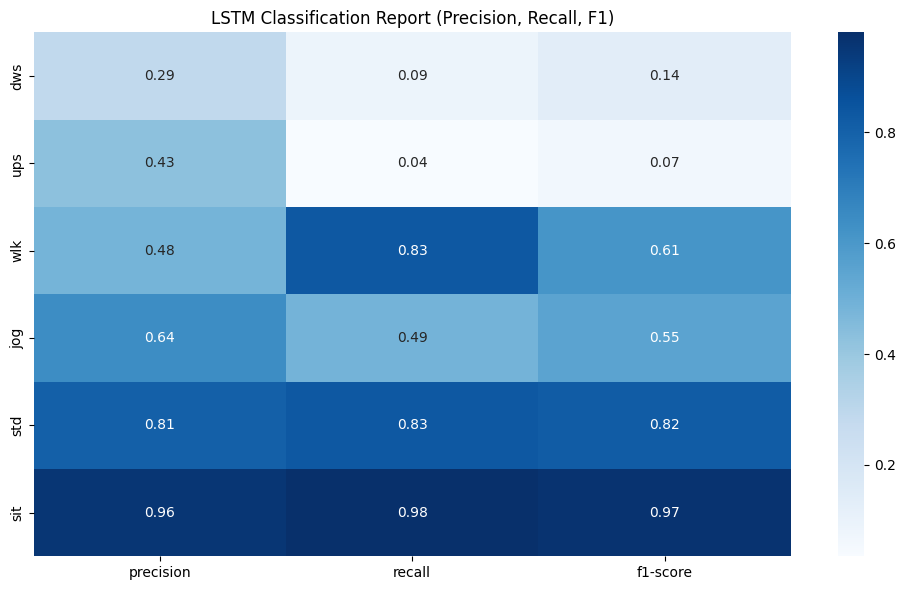

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("LSTM Classification Report (Precision, Recall, F1)")
plt.tight_layout()
plt.show()


In [19]:
lstm_metrics = {
    "Model": "LSTM",
    "Accuracy": round(test_acc / 100, 4),
    "Precision": round(report["macro avg"]["precision"], 4),
    "Recall": round(report["macro avg"]["recall"], 4),
    "F1-Score": round(report["macro avg"]["f1-score"], 4)
}
print(lstm_metrics)


{'Model': 'LSTM', 'Accuracy': 0.6681, 'Precision': 0.6012, 'Recall': 0.5428, 'F1-Score': 0.5258}


# 4. Evaluation

In [20]:
model.eval()
correct = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()

test_acc = 100 * correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 66.81%
